# Prétraitement

## Redimension

In [2]:
import os
from PIL import Image

# Dossiers de base
base_folders = {
    "left": "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train",
    "gt": "/Users/kevinroualec/Desktop/imgp8/gtFine/train"
}

# Création des dossiers de sortie "resized" pour chaque dossier train
output_folders = {key: os.path.join(folder, "resized") for key, folder in base_folders.items()}
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# Vérification si c'est une image gtFine
def is_gtfine_image(filename):
    return filename.lower().endswith('gtfine_instanceids.png')

# Stocker les images groupées par leur préfixe
grouped_images = {}

# Exploration des dossiers
for key, folder in base_folders.items():
    for city in os.listdir(folder):
        city_path = os.path.join(folder, city)
        if not os.path.isdir(city_path):
            continue

        for image_file in os.listdir(city_path):
            if key == "gt" and not is_gtfine_image(image_file):
                continue
            if key == "left" and not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            prefix = "_".join(image_file.split('_')[:3])
            grouped_images.setdefault(prefix, {"left": None, "gt": None})
            image_path = os.path.join(city_path, image_file)

            if key == "left":
                grouped_images[prefix]["left"] = image_path
            else:
                grouped_images[prefix]["gt"] = image_path

# Traitement et sauvegarde
for prefix, images in grouped_images.items():
    left_path, gt_path = images["left"], images["gt"]

    if left_path:
        try:
            left_image = Image.open(left_path).resize((1024, 512))
            save_path = os.path.join(output_folders["left"], f"{prefix}_leftImg8bit.png")
            left_image.save(save_path)
        except Exception as e:
            print(f"Erreur avec l'image gauche {prefix}: {e}")

    if gt_path:
        try:
            gt_image = Image.open(gt_path).resize((1024, 512))
            save_path = os.path.join(output_folders["gt"], f"{prefix}_gtFine_instanceIds.png")
            gt_image.save(save_path)
        except Exception as e:
            print(f"Erreur avec l'image gtFine {prefix}: {e}")

print("Redimensionnement terminé avec succès.")


Redimensionnement terminé avec succès.


In [ ]:
import os
from PIL import Image

# Dossiers de base
base_folders = {
    "left": "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train",
    "gt": "/Users/kevinroualec/Desktop/imgp8/gtFine/train"
}

# Création des dossiers de sortie "resized" pour chaque dossier train
output_folders = {key: os.path.join(folder, "resized") for key, folder in base_folders.items()}
for folder in output_folders.values():
    os.makedirs(folder, exist_ok=True)

# Vérification si c'est une image gtFine
def is_gtfine_image(filename):
    return filename.lower().endswith('gtfine_instanceids.png')

# Stocker les images groupées par leur préfixe
grouped_images = {}

# Exploration des dossiers
for key, folder in base_folders.items():
    for city in os.listdir(folder):
        city_path = os.path.join(folder, city)
        if not os.path.isdir(city_path):
            continue

        for image_file in os.listdir(city_path):
            if key == "gt" and not is_gtfine_image(image_file):
                continue
            if key == "left" and not image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            prefix = "_".join(image_file.split('_')[:3])
            grouped_images.setdefault(prefix, {"left": None, "gt": None})
            image_path = os.path.join(city_path, image_file)

            if key == "left":
                grouped_images[prefix]["left"] = image_path
            else:
                grouped_images[prefix]["gt"] = image_path

# Traitement et sauvegarde
for prefix, images in grouped_images.items():
    left_path, gt_path = images["left"], images["gt"]

    if left_path:
        try:
            left_image = Image.open(left_path).resize((512, 256))
            save_path = os.path.join(output_folders["left"], f"{prefix}_leftImg8bit.png")
            left_image.save(save_path)
        except Exception as e:
            print(f"Erreur avec l'image gauche {prefix}: {e}")

    if gt_path:
        try:
            gt_image = Image.open(gt_path).resize((512, 256))
            save_path = os.path.join(output_folders["gt"], f"{prefix}_gtFine_instanceIds.png")
            gt_image.save(save_path)
        except Exception as e:
            print(f"Erreur avec l'image gtFine {prefix}: {e}")

print("Redimensionnement terminé avec succès.")


# Unet

## Sans augmentation

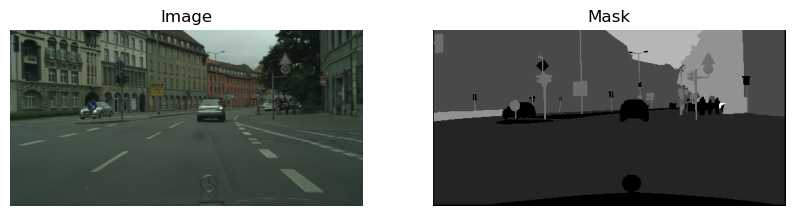

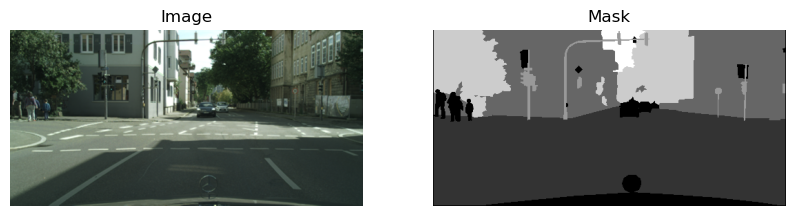

Epoch 1/50


KeyboardInterrupt: 

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple
import segmentation_models as sm

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées (comme avant)
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

# Fonction pour récupérer les chemins d'image dans les sous-dossiers
def get_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):  # Filtrer par types d'images
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_image(image_path):
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=(256, 512))  # Assure-toi que `color_mode` est par défaut à 'rgb'
        img = keras.preprocessing.image.img_to_array(img)
        return img
    except OSError as e:
        print(f"Warning: {image_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def load_mask(mask_path):
    try:
        img = keras.preprocessing.image.load_img(mask_path, target_size=(256, 512), color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)

        # Appliquer le mappage des catégories
        img = apply_category_mapping(img)  # Applique le mappage à chaque pixel du masque

        # Convertir en float32 sans normalisation (pas de division par 255)
        img = img.astype('float32')

        return img
    except OSError as e:
        print(f"Warning: {mask_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

# Fonction pour appliquer le mappage des catégories sur le masque
def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)  # S'assurer que le masque est en uint8

    for label in labels:
        # Mappe chaque ID de label à un ID numérique de catégorie
        new_mask[mask == label.id] = label.categoryId  # Utilisation de categoryId pour une catégorisation numérique

    return new_mask.astype(np.uint8)  # Conversion explicite en uint8

# Fonction de visualisation pour afficher l'image et son masque côte à côte
def visualize_sample(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image.numpy().astype('uint8'))  # Affiche l'image RGB
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask.numpy().squeeze(), cmap='gray')  # Affiche le masque en niveaux de gris
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

def data_generator(image_paths, mask_paths, batch_size, visualize=True):
    index = 0
    first_batch = True  # Flag pour contrôler l'affichage une seule fois
    shuffle_indices = np.arange(len(image_paths))  # Indices pour le shuffle
    np.random.shuffle(shuffle_indices)  # Mélanger au début

    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            if index >= len(image_paths):  # Réinitialiser et reshuffle à chaque epoch
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]

            # Extraire le nom de l'image sans son suffixe et ajuster pour le masque
            mask_filename = os.path.basename(image_path).replace('leftImg8bit', 'gtFine_instanceIds')
            mask_path = None

            for mp in mask_paths:
                if os.path.basename(mp) == mask_filename:
                    mask_path = mp
                    break

            if mask_path is None:
                print(f"Erreur: Aucun masque trouvé pour l'image {image_path}.")
                index += 1
                continue

            img = load_image(image_path)
            mask = load_mask(mask_path)
            if img is not None and mask is not None:
                if img.shape[:2] != mask.shape[:2]:
                    print(f"Erreur: L'image {image_path} et son masque {mask_path} ont des tailles différentes.")
                # Redimensionner explicitement les images et les masques
                img = tf.image.resize(img, (256, 512))
                mask = tf.image.resize(mask, (256, 512), method='nearest')

                # Vérifier les dimensions après transformation
                if img.shape[:2] != (256, 512) or mask.shape[:2] != (256, 512):
                    print(f"Erreur: L'image ou le masque n'ont pas la taille attendue après transformation.")
                    continue

                batch_images.append(img)
                batch_masks.append(mask)

            index += 1

        # Visualiser automatiquement les deux premiers couples image/mask si 'visualize' est activé
        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):  # Évite erreur si batch < 2
                visualize_sample(batch_images[i], batch_masks[i])
            first_batch = False

        yield np.array(batch_images), np.array(batch_masks)

def unet_model():
    inputs = Input((256, 512, 3))

    # Contracting path
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = keras.layers.BatchNormalization()(c1)  # Batch Normalization
    c1 = keras.layers.Dropout(0.5)(c1)  # Dropout
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = keras.layers.BatchNormalization()(c2)  # Batch Normalization
    c2 = keras.layers.Dropout(0.5)(c2)  # Dropout
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = keras.layers.BatchNormalization()(c3)  # Batch Normalization
    c3 = keras.layers.Dropout(0.5)(c3)  # Dropout
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = keras.layers.BatchNormalization()(c4)  # Batch Normalization
    c4 = keras.layers.Dropout(0.5)(c4)  # Dropout
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = keras.layers.BatchNormalization()(c5)  # Batch Normalization
    c5 = keras.layers.Dropout(0.5)(c5)  # Dropout

    # Expanding path
    u6 = keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = keras.layers.BatchNormalization()(c6)  # Batch Normalization
    c6 = keras.layers.Dropout(0.5)(c6)  # Dropout

    u7 = keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = keras.layers.BatchNormalization()(c7)  # Batch Normalization
    c7 = keras.layers.Dropout(0.5)(c7)  # Dropout

    u8 = keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = keras.layers.BatchNormalization()(c8)  # Batch Normalization
    c8 = keras.layers.Dropout(0.5)(c8)  # Dropout

    u9 = keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1])
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = keras.layers.BatchNormalization()(c9)  # Batch Normalization
    c9 = keras.layers.Dropout(0.5)(c9)  # Dropout

    outputs = keras.layers.Conv2D(8, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Initialisation du modèle
model = unet_model()

# Créez les métriques (IoU, Dice, Accuracy)
iou_metric = sm.metrics.IOUScore()
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur avec un learning rate plus élevé
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Augmente la valeur ici

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

# Paramètres d'entraînement
batch_size = 32
epochs = 50

# Récupération des images et masques pour l'entraînement
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine)

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine)

train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    # Sauvegarde le modèle uniquement lorsque le score IoU est meilleur
    ModelCheckpoint('unet_model_best_iou.keras', monitor='val_iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
    EarlyStopping(patience=25, verbose=1)
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images_paths) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

def plot_metrics(history):
    plt.figure(figsize=(16, 12))
    metrics = ['loss', 'accuracy', 'f1-score', 'iou_score']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        # Vérifier si la métrique est présente dans l'historique
        if metric in history.history:
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(metric.replace('_', ' ').capitalize())
            plt.legend()
            plt.grid()
    plt.tight_layout()
    plt.show()

def load_and_preprocess_image(image_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0       # Normalisation entre 0 et 1
    return image

def load_and_preprocess_mask(mask_path, target_size=(256, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)     # Les masques sont souvent en niveaux de gris
    mask = tf.image.resize(mask, target_size, method='nearest')  # Important pour les masques
    mask = tf.cast(mask, tf.int32)
    return mask

def visualize_prediction(image_path, mask_path, model):
    # Vérification de l'existence des fichiers
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    # Chargement de l'image et du masque
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    # Prédiction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]  # (256, 512, nb_classes)

    # Conversion des probabilités en classes (argmax)
    predicted_mask = np.argmax(prediction, axis=-1)  # (256, 512)

    # Affichage
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Mask Réel")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')  # Maintenant c'est 2D, ça fonctionne

    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_instanceIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


## Avec augmentation

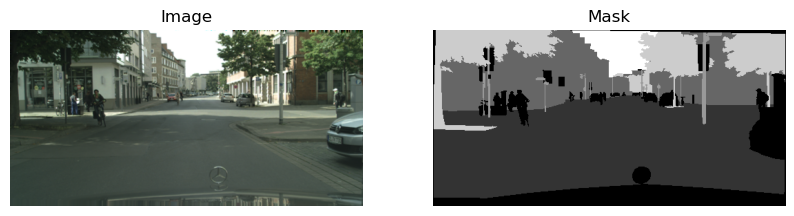

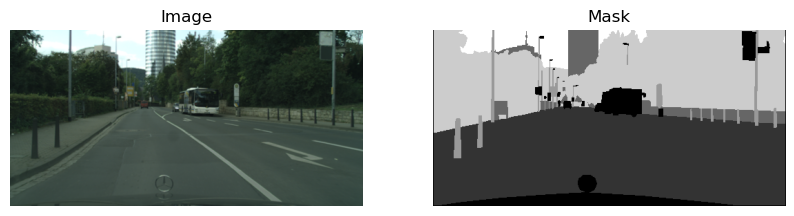

Epoch 1/50


KeyboardInterrupt: 

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from collections import namedtuple

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
import albumentations as A
from albumentations import Compose, RandomCrop, HorizontalFlip, RandomBrightnessContrast, RandomRotate90

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées (comme avant)
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

# Fonction pour récupérer les chemins d'image dans les sous-dossiers
def get_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):  # Filtrer par types d'images
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_image(image_path):
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=(256, 512))  # Assure-toi que `color_mode` est par défaut à 'rgb'
        img = keras.preprocessing.image.img_to_array(img)
        return img
    except OSError as e:
        print(f"Warning: {image_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def load_mask(mask_path):
    try:
        img = keras.preprocessing.image.load_img(mask_path, target_size=(256, 512), color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)

        # Appliquer le mappage des catégories
        img = apply_category_mapping(img)  # Applique le mappage à chaque pixel du masque

        # Convertir en float32 sans normalisation (pas de division par 255)
        img = img.astype('float32')

        return img
    except OSError as e:
        print(f"Warning: {mask_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

# Fonction pour appliquer le mappage des catégories sur le masque
def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)  # S'assurer que le masque est en uint8

    for label in labels:
        # Mappe chaque ID de label à un ID numérique de catégorie
        new_mask[mask == label.id] = label.categoryId  # Utilisation de categoryId pour une catégorisation numérique

    return new_mask.astype(np.uint8)  # Conversion explicite en uint8

# Fonction de visualisation pour afficher l'image et son masque côte à côte
def visualize_sample(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image.astype('uint8'))  # Affiche l'image RGB
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')  # Affiche le masque en niveaux de gris
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# Définir les transformations d'augmentation
transform = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
], p=1.0)  # S'assurer que toutes les images passent par les transformations

def data_generator(image_paths, mask_paths, batch_size, visualize=True):
    index = 0
    first_batch = True  # Flag pour contrôler l'affichage une seule fois
    shuffle_indices = np.arange(len(image_paths))  # Indices pour le shuffle
    np.random.shuffle(shuffle_indices)  # Mélanger au début

    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            if index >= len(image_paths):  # Réinitialiser et reshuffle à chaque epoch
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]

            # Extraire le nom de l'image sans son suffixe et ajuster pour le masque
            mask_filename = os.path.basename(image_path).replace('leftImg8bit', 'gtFine_instanceIds')
            mask_path = None

            for mp in mask_paths:
                if os.path.basename(mp) == mask_filename:
                    mask_path = mp
                    break

            if mask_path is None:
                print(f"Erreur: Aucun masque trouvé pour l'image {image_path}.")
                index += 1
                continue

            img = load_image(image_path)
            mask = load_mask(mask_path)
            if img is not None and mask is not None:
                if img.shape[:2] != mask.shape[:2]:
                    print(f"Erreur: L'image {image_path} et son masque {mask_path} ont des tailles différentes.")
                # Redimensionner explicitement les images et les masques
                img = A.Resize(height=256, width=512)(image=img)['image']
                mask = A.Resize(height=256, width=512)(image=mask)['image']

                # Appliquer les transformations d'augmentation
                augmented = transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

                # Vérifier les dimensions après transformation
                if img.shape[:2] != (256, 512) or mask.shape[:2] != (256, 512):
                    print(f"Erreur: L'image ou le masque n'ont pas la taille attendue après transformation.")
                    continue

                batch_images.append(img)
                batch_masks.append(mask)

            index += 1

        # Visualiser automatiquement les deux premiers couples image/mask si 'visualize' est activé
        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):  # Évite erreur si batch < 2
                visualize_sample(batch_images[i], batch_masks[i])
            first_batch = False

        yield np.array(batch_images), np.array(batch_masks)

def unet_model():
    inputs = Input((256, 512, 3))

    # Contracting path
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = keras.layers.BatchNormalization()(c1)  # Batch Normalization
    c1 = keras.layers.Dropout(0.5)(c1)  # Dropout
    p1 = keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = keras.layers.BatchNormalization()(c2)  # Batch Normalization
    c2 = keras.layers.Dropout(0.5)(c2)  # Dropout
    p2 = keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = keras.layers.BatchNormalization()(c3)  # Batch Normalization
    c3 = keras.layers.Dropout(0.5)(c3)  # Dropout
    p3 = keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = keras.layers.BatchNormalization()(c4)  # Batch Normalization
    c4 = keras.layers.Dropout(0.5)(c4)  # Dropout
    p4 = keras.layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = keras.layers.BatchNormalization()(c5)  # Batch Normalization
    c5 = keras.layers.Dropout(0.5)(c5)  # Dropout

    # Expanding path
    u6 = keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = keras.layers.concatenate([u6, c4])
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = keras.layers.BatchNormalization()(c6)  # Batch Normalization
    c6 = keras.layers.Dropout(0.5)(c6)  # Dropout

    u7 = keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = keras.layers.concatenate([u7, c3])
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = keras.layers.BatchNormalization()(c7)  # Batch Normalization
    c7 = keras.layers.Dropout(0.5)(c7)  # Dropout

    u8 = keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = keras.layers.concatenate([u8, c2])
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = keras.layers.BatchNormalization()(c8)  # Batch Normalization
    c8 = keras.layers.Dropout(0.5)(c8)  # Dropout

    u9 = keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = keras.layers.concatenate([u9, c1])
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = keras.layers.BatchNormalization()(c9)  # Batch Normalization
    c9 = keras.layers.Dropout(0.5)(c9)  # Dropout

    outputs = keras.layers.Conv2D(8, (1, 1), activation='softmax')(c9)

    model = Model(inputs, outputs)
    return model

# Initialisation du modèle
model = unet_model()

# Créez les métriques (IoU, Dice, Accuracy)
iou_metric = sm.metrics.IOUScore()
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur avec un learning rate plus élevé
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Augmente la valeur ici

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

# Paramètres d'entraînement
batch_size = 32
epochs = 50

# Récupération des images et masques pour l'entraînement
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine)

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine)

train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    # Sauvegarde le modèle uniquement lorsque le score IoU est meilleur
    ModelCheckpoint('unet_model_best_iou_aug.keras', monitor='val_iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
    EarlyStopping(patience=25, verbose=1)
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images_paths) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

def plot_metrics(history):
    plt.figure(figsize=(16, 12))
    metrics = ['loss', 'accuracy', 'f1-score', 'iou_score']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        # Vérifier si la métrique est présente dans l'historique
        if metric in history.history:
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(metric.replace('_', ' ').capitalize())
            plt.legend()
            plt.grid()
    plt.tight_layout()
    plt.show()

def load_and_preprocess_image(image_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0       # Normalisation entre 0 et 1
    return image

def load_and_preprocess_mask(mask_path, target_size=(256, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)     # Les masques sont souvent en niveaux de gris
    mask = tf.image.resize(mask, target_size, method='nearest')  # Important pour les masques
    mask = tf.cast(mask, tf.int32)
    return mask

def visualize_prediction(image_path, mask_path, model):
    # Vérification de l'existence des fichiers
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    # Chargement de l'image et du masque
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    # Prédiction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]  # (256, 512, nb_classes)

    # Conversion des probabilités en classes (argmax)
    predicted_mask = np.argmax(prediction, axis=-1)  # (256, 512)

    # Affichage
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Mask Réel")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')  # Maintenant c'est 2D, ça fonctionne

    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_instanceIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)

# UNET + resnet50

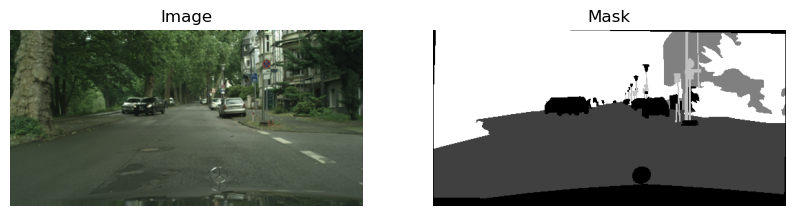

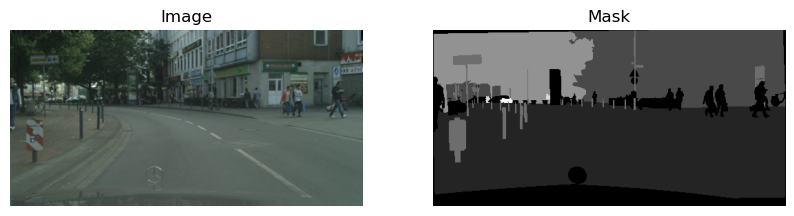

Epoch 1/50
 1/92 ━━━━━━━━━━━━━━━━━━━━ 28:03 19s/step - accuracy: 0.1354 - f1-score: 0.2329 - iou_score: 0.1320 - loss: 2.6397

KeyboardInterrupt: 

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Dropout, Concatenate, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import ResNet50
from collections import namedtuple
import albumentations as A
from albumentations import Compose, RandomCrop, HorizontalFlip, RandomBrightnessContrast, RandomRotate90
import segmentation_models as sm

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées (comme avant)
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

# Fonction pour récupérer les chemins d'image dans les sous-dossiers
def get_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):  # Filtrer par types d'images
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_image(image_path):
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=(256, 512))  # Assure-toi que `color_mode` est par défaut à 'rgb'
        img = keras.preprocessing.image.img_to_array(img)
        return img
    except OSError as e:
        print(f"Warning: {image_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

def load_mask(mask_path):
    try:
        img = keras.preprocessing.image.load_img(mask_path, target_size=(256, 512), color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)

        # Appliquer le mappage des catégories
        img = apply_category_mapping(img)  # Applique le mappage à chaque pixel du masque

        # Convertir en float32 sans normalisation (pas de division par 255)
        img = img.astype('float32')

        return img
    except OSError as e:
        print(f"Warning: {mask_path} is corrupted or cannot be loaded. Skipping this file.")
        return None

# Fonction pour appliquer le mappage des catégories sur le masque
def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)  # S'assurer que le masque est en uint8

    for label in labels:
        # Mappe chaque ID de label à un ID numérique de catégorie
        new_mask[mask == label.id] = label.categoryId  # Utilisation de categoryId pour une catégorisation numérique

    return new_mask.astype(np.uint8)  # Conversion explicite en uint8

# Fonction de visualisation pour afficher l'image et son masque côte à côte
def visualize_sample(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image.astype('uint8'))  # Affiche l'image RGB
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')  # Affiche le masque en niveaux de gris
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# Définir les transformations d'augmentation
transform = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
], p=1.0)  # S'assurer que toutes les images passent par les transformations

def data_generator(image_paths, mask_paths, batch_size, visualize=True):
    index = 0
    first_batch = True  # Flag pour contrôler l'affichage une seule fois
    shuffle_indices = np.arange(len(image_paths))  # Indices pour le shuffle
    np.random.shuffle(shuffle_indices)  # Mélanger au début

    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            if index >= len(image_paths):  # Réinitialiser et reshuffle à chaque epoch
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]

            # Extraire le nom de l'image sans son suffixe et ajuster pour le masque
            mask_filename = os.path.basename(image_path).replace('leftImg8bit', 'gtFine_instanceIds')
            mask_path = None

            for mp in mask_paths:
                if os.path.basename(mp) == mask_filename:
                    mask_path = mp
                    break

            if mask_path is None:
                print(f"Erreur: Aucun masque trouvé pour l'image {image_path}.")
                index += 1
                continue

            img = load_image(image_path)
            mask = load_mask(mask_path)
            if img is not None and mask is not None:
                if img.shape[:2] != mask.shape[:2]:
                    print(f"Erreur: L'image {image_path} et son masque {mask_path} ont des tailles différentes.")
                # Redimensionner explicitement les images et les masques
                img = A.Resize(height=256, width=512)(image=img)['image']
                mask = A.Resize(height=256, width=512)(image=mask)['image']

                # Appliquer les transformations d'augmentation
                augmented = transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

                # Vérifier les dimensions après transformation
                if img.shape[:2] != (256, 512) or mask.shape[:2] != (256, 512):
                    print(f"Erreur: L'image ou le masque n'ont pas la taille attendue après transformation.")
                    continue

                batch_images.append(img)
                batch_masks.append(mask)

            index += 1

        # Visualiser automatiquement les deux premiers couples image/mask si 'visualize' est activé
        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):  # Évite erreur si batch < 2
                visualize_sample(batch_images[i], batch_masks[i])
            first_batch = False

        yield np.array(batch_images), np.array(batch_masks)

from keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, BatchNormalization, Dropout, UpSampling2D, Cropping2D
from keras.models import Model
from keras.applications import ResNet50

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Utiliser ResNet50 comme encodeur
    resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    # Geler les couches de ResNet50 pour utiliser les poids pré-entraînés
    for layer in resnet.layers:
        layer.trainable = False

    # Extraire les sorties des blocs de ResNet50 pour les connexions de saut
    skip1 = resnet.get_layer('conv2_block3_out').output  # 128x256x256
    skip2 = resnet.get_layer('conv3_block4_out').output  # 64x128x512
    skip3 = resnet.get_layer('conv4_block6_out').output  # 32x64x1024
    skip4 = resnet.get_layer('conv5_block3_out').output  # 16x32x2048
    bridge = resnet.get_layer('conv5_block3_out').output  # 16x32x2048

    # Ajuster les dimensions des couches de saut
    skip4_adj = Conv2D(1024, (1, 1), padding='same')(skip4)
    skip3_adj = Conv2D(512, (1, 1), padding='same')(skip3)
    skip2_adj = Conv2D(256, (1, 1), padding='same')(skip2)
    skip1_adj = Conv2D(128, (1, 1), padding='same')(skip1)

    # Expanding path
    d1 = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(bridge)
    
    # Adapter les tailles avant concaténation
    skip4_adj = UpSampling2D(size=(2, 2), interpolation='bilinear')(skip4_adj)  # Double la taille de skip4_adj
    skip4_adj = Cropping2D(cropping=((0, 0), (0, 0)))(skip4_adj)  # Ajuste la taille précisément si nécessaire
    
    d1 = Concatenate()([d1, skip4_adj])  # Maintenant les tailles doivent correspondre
    d1 = Conv2D(1024, (3, 3), activation='relu', padding='same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.5)(d1)
    d1 = Conv2D(1024, (3, 3), activation='relu', padding='same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.5)(d1)

    # Ajuster la taille de skip3_adj avant la concaténation
    skip3_adj = UpSampling2D(size=(2, 2), interpolation='bilinear')(skip3_adj)

    d2 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(d1)
    d2 = Concatenate()([d2, skip3_adj])  # Maintenant les tailles doivent correspondre
    d2 = Conv2D(512, (3, 3), activation='relu', padding='same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)
    d2 = Conv2D(512, (3, 3), activation='relu', padding='same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.5)(d2)

    # Ajuster la taille de skip2_adj avant la concaténation
    skip2_adj = UpSampling2D(size=(2, 2), interpolation='bilinear')(skip2_adj)

    d3 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(d2)
    d3 = Concatenate()([d3, skip2_adj])  # Maintenant les tailles doivent correspondre
    d3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Dropout(0.5)(d3)
    d3 = Conv2D(256, (3, 3), activation='relu', padding='same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Dropout(0.5)(d3)

    # Ajuster la taille de skip1_adj avant la concaténation
    skip1_adj = UpSampling2D(size=(2, 2), interpolation='bilinear')(skip1_adj)

    d4 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(d3)
    d4 = Concatenate()([d4, skip1_adj])
    d4 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Dropout(0.5)(d4)
    d4 = Conv2D(128, (3, 3), activation='relu', padding='same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Dropout(0.5)(d4)

    # Ajuster la taille d'upSampling pour d4 avant la sortie
    d4 = UpSampling2D(size=(2, 2), interpolation='bilinear')(d4)

    outputs = Conv2D(8, (1, 1), activation='softmax', padding='same')(d4)

    model = Model(inputs, outputs)
    return model

# Initialisation du modèle
model = build_unet((256, 512, 3))



# Créez les métriques (IoU, Dice, Accuracy)
iou_metric = sm.metrics.IOUScore()
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur avec un learning rate plus élevé
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Augmente la valeur ici

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

# Paramètres d'entraînement
batch_size = 32
epochs = 50

# Récupération des images et masques pour l'entraînement
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine)

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine)

train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    # Sauvegarde le modèle uniquement lorsque le score IoU est meilleur
    ModelCheckpoint('unet_model_best_iou_res.keras', monitor='val_iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
    EarlyStopping(patience=25, verbose=1)
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images_paths) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

def plot_metrics(history):
    plt.figure(figsize=(16, 12))
    metrics = ['loss', 'accuracy', 'f1-score', 'iou_score']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        # Vérifier si la métrique est présente dans l'historique
        if metric in history.history:
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(metric.replace('_', ' ').capitalize())
            plt.legend()
            plt.grid()
    plt.tight_layout()
    plt.show()

def load_and_preprocess_image(image_path, target_size=(256, 512)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float32) / 255.0       # Normalisation entre 0 et 1
    return image

def load_and_preprocess_mask(mask_path, target_size=(256, 512)):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)     # Les masques sont souvent en niveaux de gris
    mask = tf.image.resize(mask, target_size, method='nearest')  # Important pour les masques
    mask = tf.cast(mask, tf.int32)
    return mask

def visualize_prediction(image_path, mask_path, model):
    # Vérification de l'existence des fichiers
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    # Chargement de l'image et du masque
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    # Prédiction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]  # (256, 512, nb_classes)

    # Conversion des probabilités en classes (argmax)
    predicted_mask = np.argmax(prediction, axis=-1)  # (256, 512)

    # Affichage
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Mask Réel")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')  # Maintenant c'est 2D, ça fonctionne

    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_instanceIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


# EfficientNet + FPN

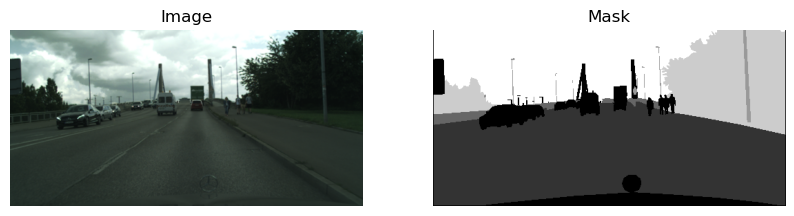

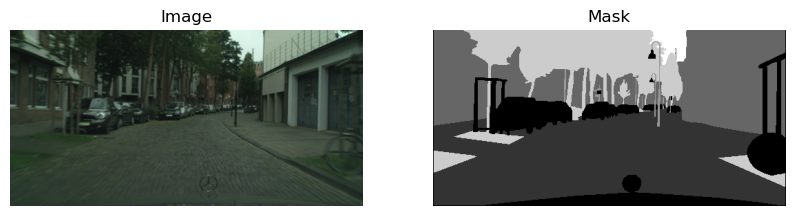

Epoch 1/50
  1/371 ━━━━━━━━━━━━━━━━━━━━ 5:12:24 51s/step - accuracy: 0.1105 - f1-score: 0.2290 - iou_score: 0.1330 - loss: 2.4310

KeyboardInterrupt: 

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, UpSampling2D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB3
from collections import namedtuple
import albumentations as A
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast
import segmentation_models as sm

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

# Fonction pour récupérer les chemins d'image dans les sous-dossiers
def get_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):  # Filtrer par types d'images
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_image(image_path):
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=(256, 512))  # Assure-toi que `color_mode` est par défaut à 'rgb'
        img = keras.preprocessing.image.img_to_array(img)
        return img
    except Exception as e:
        print(f"Warning: {image_path} is corrupted or cannot be loaded. Skipping this file. Error: {e}")
        return None

def load_mask(mask_path):
    try:
        img = keras.preprocessing.image.load_img(mask_path, target_size=(256, 512), color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)

        # Appliquer le mappage des catégories
        img = apply_category_mapping(img)  # Applique le mappage à chaque pixel du masque

        # Convertir en float32 sans normalisation (pas de division par 255)
        img = img.astype('float32')

        return img
    except Exception as e:
        print(f"Warning: {mask_path} is corrupted or cannot be loaded. Skipping this file. Error: {e}")
        return None

# Fonction pour appliquer le mappage des catégories sur le masque
def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)  # S'assurer que le masque est en uint8

    for label in labels:
        # Mappe chaque ID de label à un ID numérique de catégorie
        new_mask[mask == label.id] = label.categoryId  # Utilisation de categoryId pour une catégorisation numérique

    return new_mask.astype(np.uint8)  # Conversion explicite en uint8

# Fonction de visualisation pour afficher l'image et son masque côte à côte
def visualize_sample(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image.astype('uint8'))  # Affiche l'image RGB
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')  # Affiche le masque en niveaux de gris
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# Définir les transformations d'augmentation
transform = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
], p=1.0)  # S'assurer que toutes les images passent par les transformations

def data_generator(image_paths, mask_paths, batch_size, visualize=True):
    index = 0
    first_batch = True  # Flag pour contrôler l'affichage une seule fois
    shuffle_indices = np.arange(len(image_paths))  # Indices pour le shuffle
    np.random.shuffle(shuffle_indices)  # Mélanger au début

    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            if index >= len(image_paths):  # Réinitialiser et reshuffle à chaque epoch
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]

            # Extraire le nom de l'image sans son suffixe et ajuster pour le masque
            mask_filename = os.path.basename(image_path).replace('leftImg8bit', 'gtFine_instanceIds')
            mask_path = None

            for mp in mask_paths:
                if os.path.basename(mp) == mask_filename:
                    mask_path = mp
                    break

            if mask_path is None:
                print(f"Erreur: Aucun masque trouvé pour l'image {image_path}.")
                index += 1
                continue

            img = load_image(image_path)
            mask = load_mask(mask_path)
            if img is not None and mask is not None:
                if img.shape[:2] != mask.shape[:2]:
                    print(f"Erreur: L'image {image_path} et son masque {mask_path} ont des tailles différentes.")
                # Redimensionner explicitement les images et les masques
                img = A.Resize(height=256, width=512)(image=img)['image']
                mask = A.Resize(height=256, width=512)(image=mask)['image']

                # Appliquer les transformations d'augmentation
                augmented = transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

                # Vérifier les dimensions après transformation
                if img.shape[:2] != (256, 512) or mask.shape[:2] != (256, 512):
                    print(f"Erreur: L'image ou le masque n'ont pas la taille attendue après transformation.")
                    continue

                batch_images.append(img)
                batch_masks.append(mask)

            index += 1

        # Visualiser automatiquement les deux premiers couples image/mask si 'visualize' est activé
        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):  # Évite erreur si batch < 2
                visualize_sample(batch_images[i], batch_masks[i])
            first_batch = False

        yield np.array(batch_images), np.array(batch_masks)

def build_efficientnet_fpn(input_shape):
    inputs = Input(input_shape)

    # Charger EfficientNetB3 comme backbone pré-entraîné
    backbone = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=inputs)

    # Couches intermédiaires (skip connections)
    skip1 = backbone.get_layer('block2b_add').output  # Niveau 1
    skip2 = backbone.get_layer('block3b_add').output  # Niveau 2
    skip3 = backbone.get_layer('block4c_add').output  # Niveau 3
    skip4 = backbone.get_layer('block6e_add').output  # Niveau 4
    bridge = backbone.get_layer('top_conv').output    # Niveau 5 (bottle-neck)

    # Feature Pyramid Network (FPN)
    fpn1 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip4)
    fpn1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(fpn1)  # Ajustement d'upsampling

    fpn2 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip3)
    fpn2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(fpn2)  # Ajustement d'upsampling

    fpn3 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip2)
    fpn3 = UpSampling2D(size=(1, 1), interpolation='bilinear')(fpn3)  # Ajustement d'upsampling

    fpn4 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip1)

    # Redimensionner toutes les cartes de caractéristiques à la même taille
    target_size = (256, 512)  # Taille finale attendue

    fpn1 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn1)
    fpn2 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn2)
    fpn3 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn3)
    fpn4 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn4)

    # Fusionner les cartes de caractéristiques
    fpn_combined = Concatenate()([fpn1, fpn2, fpn3, fpn4])

    # Decoder: Upsampling + convolution
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(fpn_combined)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Dernière couche de segmentation
    outputs = Conv2D(8, (1, 1), activation='softmax', padding='same')(x)  # 8 classes

    # Redimensionner la sortie pour qu'elle corresponde exactement à la taille des cibles
    outputs = Lambda(lambda x: tf.image.resize(x, target_size))(outputs)

    # Créer le modèle
    model = Model(inputs, outputs)
    return model

# Initialisation du modèle
model = build_efficientnet_fpn((256, 512, 3))

# Créez les métriques (IoU, Dice, Accuracy)
iou_metric = sm.metrics.IOUScore()
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur avec un learning rate plus élevé
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Augmente la valeur ici

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

# Paramètres d'entraînement
batch_size = 8  # Réduire la taille du batch pour éviter les problèmes de mémoire
epochs = 50

# Récupération des images et masques pour l'entraînement
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine)

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine)

train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    # Sauvegarde le modèle uniquement lorsque le score IoU est meilleur
    ModelCheckpoint('efficientnet_fpn_model_best_iou_eff.keras', monitor='val_iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
    EarlyStopping(patience=25, verbose=1)
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images_paths) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

# Fonction pour visualiser les métriques
def plot_metrics(history):
    plt.figure(figsize=(16, 12))
    metrics = ['loss', 'accuracy', 'f1-score', 'iou_score']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        # Vérifier si la métrique est présente dans l'historique
        if metric in history.history:
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(metric.replace('_', ' ').capitalize())
            plt.legend()
            plt.grid()
    plt.tight_layout()
    plt.show()

# Fonction pour visualiser les prédictions
def visualize_prediction(image_path, mask_path, model):
    # Vérification de l'existence des fichiers
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    # Chargement de l'image et du masque
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    # Prédiction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]  # (256, 512, nb_classes)

    # Conversion des probabilités en classes (argmax)
    predicted_mask = np.argmax(prediction, axis=-1)  # (256, 512)

    # Affichage
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Mask Réel")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')  # Maintenant c'est 2D, ça fonctionne

    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_instanceIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)


## Changement loss

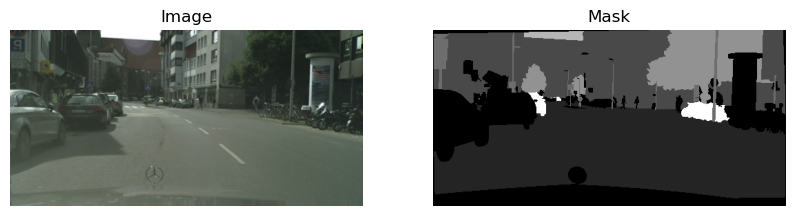

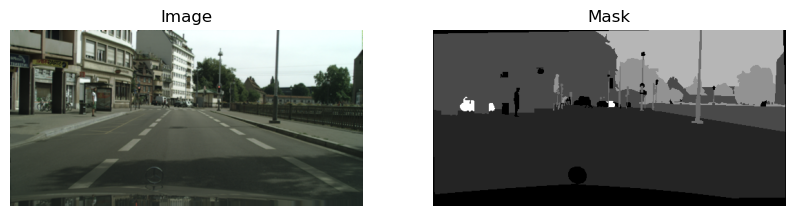

Epoch 1/50
  1/371 ━━━━━━━━━━━━━━━━━━━━ 5:25:39 53s/step - accuracy: 0.3194 - f1-score: 0.2294 - iou_score: 0.1347 - loss: 2.8249

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate, UpSampling2D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.applications import EfficientNetB3
from collections import namedtuple
import albumentations as A
from albumentations import Compose, HorizontalFlip, RandomBrightnessContrast
import segmentation_models as sm

# Assurer la compatibilité avec tensorflow.keras
os.environ["SM_FRAMEWORK"] = "tf.keras"

# Définition de la structure Label
Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color'
])

# Liste complète des labels
labels = [
    Label('unlabeled', 0, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('ego vehicle', 1, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('rectification border', 2, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('out of roi', 3, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('static', 4, 255, 'void', 0, False, True, (0, 0, 0)),
    Label('dynamic', 5, 255, 'void', 0, False, True, (111, 74, 0)),
    Label('ground', 6, 255, 'void', 0, False, True, (81, 0, 81)),
    Label('road', 7, 0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk', 8, 1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking', 9, 255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10, 255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11, 2, 'construction', 2, False, False, (70, 70, 70)),
    Label('wall', 12, 3, 'construction', 2, False, False, (102, 102, 156)),
    Label('fence', 13, 4, 'construction', 2, False, False, (190, 153, 153)),
    Label('guard rail', 14, 255, 'construction', 2, False, True, (180, 165, 180)),
    Label('bridge', 15, 255, 'construction', 2, False, True, (150, 100, 100)),
    Label('tunnel', 16, 255, 'construction', 2, False, True, (150, 120, 90)),
    Label('pole', 17, 5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18, 255, 'object', 3, False, True, (153, 153, 153)),
    Label('traffic light', 19, 6, 'object', 3, False, False, (250, 170, 30)),
    Label('traffic sign', 20, 7, 'object', 3, False, False, (220, 220, 0)),
    Label('vegetation', 21, 8, 'nature', 4, False, False, (107, 142, 35)),
    Label('terrain', 22, 9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23, 10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24, 11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25, 12, 'human', 6, True, False, (255, 0, 0)),
    Label('car', 26, 13, 'vehicle', 7, True, False, (0, 0, 142)),
    Label('truck', 27, 14, 'vehicle', 7, True, False, (0, 0, 70)),
    Label('bus', 28, 15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29, 255, 'vehicle', 7, True, True, (0, 0, 90)),
    Label('trailer', 30, 255, 'vehicle', 7, True, True, (0, 0, 110)),
    Label('train', 31, 16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32, 17, 'vehicle', 7, True, False, (0, 0, 230)),
    Label('bicycle', 33, 18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1, -1, 'vehicle', 7, False, True, (0, 0, 142)),
]

# Dictionnaire pour regrouper les catId à des noms de catégories simplifiées
category_mapping = {
    0: 'void',
    1: 'flat',
    2: 'construction',
    3: 'object',
    4: 'nature',
    5: 'sky',
    6: 'human',
    7: 'vehicle',
}

# Fonction pour mapper les catId aux catégories simplifiées
def map_category(label):
    new_category = category_mapping.get(label.categoryId, 'unknown')
    return Label(
        name=label.name,
        id=label.id,
        trainId=label.trainId,
        category=new_category,
        categoryId=label.categoryId,
        hasInstances=label.hasInstances,
        ignoreInEval=label.ignoreInEval,
        color=label.color
    )

# Application de la fonction avec une compréhension de liste
grouped_labels = [map_category(label) for label in labels]

# Chemins des images redimensionnées pour l'entraînement et la validation
train_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/train/resized"
train_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/train/resized"
val_images_dir_left = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val"
val_images_dir_gtfine = "/Users/kevinroualec/Desktop/imgp8/gtFine/val"

# Fonction pour récupérer les chemins d'image dans les sous-dossiers
def get_image_paths(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.tif', '.bmp')):  # Filtrer par types d'images
                image_paths.append(os.path.join(root, file))
    return image_paths

def load_image(image_path):
    try:
        img = keras.preprocessing.image.load_img(image_path, target_size=(256, 512))  # Assure-toi que `color_mode` est par défaut à 'rgb'
        img = keras.preprocessing.image.img_to_array(img)
        return img
    except Exception as e:
        print(f"Warning: {image_path} is corrupted or cannot be loaded. Skipping this file. Error: {e}")
        return None

def load_mask(mask_path):
    try:
        img = keras.preprocessing.image.load_img(mask_path, target_size=(256, 512), color_mode="grayscale")
        img = keras.preprocessing.image.img_to_array(img)

        # Appliquer le mappage des catégories
        img = apply_category_mapping(img)  # Applique le mappage à chaque pixel du masque

        # Convertir en float32 sans normalisation (pas de division par 255)
        img = img.astype('float32')

        return img
    except Exception as e:
        print(f"Warning: {mask_path} is corrupted or cannot be loaded. Skipping this file. Error: {e}")
        return None

# Fonction pour appliquer le mappage des catégories sur le masque
def apply_category_mapping(mask):
    new_mask = np.zeros_like(mask, dtype=np.uint8)  # S'assurer que le masque est en uint8

    for label in labels:
        # Mappe chaque ID de label à un ID numérique de catégorie
        new_mask[mask == label.id] = label.categoryId  # Utilisation de categoryId pour une catégorisation numérique

    return new_mask.astype(np.uint8)  # Conversion explicite en uint8

# Fonction de visualisation pour afficher l'image et son masque côte à côte
def visualize_sample(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(image.astype('uint8'))  # Affiche l'image RGB
    axs[0].set_title('Image')
    axs[0].axis('off')

    axs[1].imshow(mask.squeeze(), cmap='gray')  # Affiche le masque en niveaux de gris
    axs[1].set_title('Mask')
    axs[1].axis('off')

    plt.show()

# Définir les transformations d'augmentation
transform = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.2),
], p=1.0)  # S'assurer que toutes les images passent par les transformations

def data_generator(image_paths, mask_paths, batch_size, visualize=True):
    index = 0
    first_batch = True  # Flag pour contrôler l'affichage une seule fois
    shuffle_indices = np.arange(len(image_paths))  # Indices pour le shuffle
    np.random.shuffle(shuffle_indices)  # Mélanger au début

    while True:
        batch_images = []
        batch_masks = []

        for _ in range(batch_size):
            if index >= len(image_paths):  # Réinitialiser et reshuffle à chaque epoch
                index = 0
                np.random.shuffle(shuffle_indices)

            shuffled_idx = shuffle_indices[index]
            image_path = image_paths[shuffled_idx]

            # Extraire le nom de l'image sans son suffixe et ajuster pour le masque
            mask_filename = os.path.basename(image_path).replace('leftImg8bit', 'gtFine_instanceIds')
            mask_path = None

            for mp in mask_paths:
                if os.path.basename(mp) == mask_filename:
                    mask_path = mp
                    break

            if mask_path is None:
                print(f"Erreur: Aucun masque trouvé pour l'image {image_path}.")
                index += 1
                continue

            img = load_image(image_path)
            mask = load_mask(mask_path)
            if img is not None and mask is not None:
                if img.shape[:2] != mask.shape[:2]:
                    print(f"Erreur: L'image {image_path} et son masque {mask_path} ont des tailles différentes.")
                # Redimensionner explicitement les images et les masques
                img = A.Resize(height=256, width=512)(image=img)['image']
                mask = A.Resize(height=256, width=512)(image=mask)['image']

                # Appliquer les transformations d'augmentation
                augmented = transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

                # Vérifier les dimensions après transformation
                if img.shape[:2] != (256, 512) or mask.shape[:2] != (256, 512):
                    print(f"Erreur: L'image ou le masque n'ont pas la taille attendue après transformation.")
                    continue

                batch_images.append(img)
                batch_masks.append(mask)

            index += 1

        # Visualiser automatiquement les deux premiers couples image/mask si 'visualize' est activé
        if visualize and first_batch:
            for i in range(min(2, len(batch_images))):  # Évite erreur si batch < 2
                visualize_sample(batch_images[i], batch_masks[i])
            first_batch = False

        yield np.array(batch_images), np.array(batch_masks)

# Fonction de perte combinée : Dice + Cross Entropy
def combined_loss(y_true, y_pred):
    dice_loss = sm.losses.DiceLoss(class_weights=np.ones(8))(y_true, y_pred)  # Dice Loss
    ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true, y_pred)  # Cross Entropy Loss
    return dice_loss + ce_loss

def build_efficientnet_fpn(input_shape):
    inputs = Input(input_shape)

    # Charger EfficientNetB3 comme backbone pré-entraîné
    backbone = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=inputs)

    # Couches intermédiaires (skip connections)
    skip1 = backbone.get_layer('block2b_add').output  # Niveau 1
    skip2 = backbone.get_layer('block3b_add').output  # Niveau 2
    skip3 = backbone.get_layer('block4c_add').output  # Niveau 3
    skip4 = backbone.get_layer('block6e_add').output  # Niveau 4
    bridge = backbone.get_layer('top_conv').output    # Niveau 5 (bottle-neck)

    # Feature Pyramid Network (FPN)
    fpn1 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip4)
    fpn1 = UpSampling2D(size=(4, 4), interpolation='bilinear')(fpn1)  # Ajustement d'upsampling

    fpn2 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip3)
    fpn2 = UpSampling2D(size=(2, 2), interpolation='bilinear')(fpn2)  # Ajustement d'upsampling

    fpn3 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip2)
    fpn3 = UpSampling2D(size=(1, 1), interpolation='bilinear')(fpn3)  # Ajustement d'upsampling

    fpn4 = Conv2D(256, (1, 1), activation='relu', padding='same')(skip1)

    # Redimensionner toutes les cartes de caractéristiques à la même taille
    target_size = (256, 512)  # Taille finale attendue

    fpn1 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn1)
    fpn2 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn2)
    fpn3 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn3)
    fpn4 = Lambda(lambda x: tf.image.resize(x, target_size))(fpn4)

    # Fusionner les cartes de caractéristiques
    fpn_combined = Concatenate()([fpn1, fpn2, fpn3, fpn4])

    # Decoder: Upsampling + convolution
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(fpn_combined)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Dernière couche de segmentation
    outputs = Conv2D(8, (1, 1), activation='softmax', padding='same')(x)  # 8 classes

    # Redimensionner la sortie pour qu'elle corresponde exactement à la taille des cibles
    outputs = Lambda(lambda x: tf.image.resize(x, target_size))(outputs)

    # Créer le modèle
    model = Model(inputs, outputs)
    return model

# Initialisation du modèle
model = build_efficientnet_fpn((256, 512, 3))

# Créer les métriques (IoU, Dice, Accuracy)
iou_metric = sm.metrics.IOUScore()
dice_metric = sm.metrics.FScore(beta=1)
accuracy_metric = 'accuracy'

# Définition d'un optimiseur avec un learning rate plus élevé
optimizer = keras.optimizers.Adam(learning_rate=0.001)  # Augmente la valeur ici

# Compilation du modèle
model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[iou_metric, dice_metric, accuracy_metric]
)

# Paramètres d'entraînement
batch_size = 8  # Réduire la taille du batch pour éviter les problèmes de mémoire
epochs = 50

# Récupération des images et masques pour l'entraînement
train_images_paths = get_image_paths(train_images_dir_left)
train_mask_paths = get_image_paths(train_images_dir_gtfine)

val_images_paths = get_image_paths(val_images_dir_left)
val_mask_paths = get_image_paths(val_images_dir_gtfine)

train_gen = data_generator(train_images_paths, train_mask_paths, batch_size)
val_gen = data_generator(val_images_paths, val_mask_paths, batch_size)

# Callbacks
callbacks = [
    # Sauvegarde le modèle uniquement lorsque le score IoU est meilleur
    ModelCheckpoint('efficientnet_fpn_model_best_iou_combined_loss.keras', monitor='val_iou_score', save_best_only=True, mode='max', verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
    EarlyStopping(patience=25, verbose=1)
]

# Entraînement du modèle
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_images_paths) // batch_size,
    validation_data=val_gen,
    validation_steps=len(val_images_paths) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

# Fonction pour visualiser les métriques
def plot_metrics(history):
    plt.figure(figsize=(16, 12))
    metrics = ['loss', 'accuracy', 'f1-score', 'iou_score']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        # Vérifier si la métrique est présente dans l'historique
        if metric in history.history:
            plt.plot(history.history[metric], label=f'Train {metric}')
            plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
            plt.title(metric.replace('_', ' ').capitalize())
            plt.legend()
            plt.grid()
    plt.tight_layout()
    plt.show()

# Fonction pour visualiser les prédictions
def visualize_prediction(image_path, mask_path, model):
    # Vérification de l'existence des fichiers
    assert os.path.exists(image_path), f"Erreur : {image_path} n'existe pas !"
    assert os.path.exists(mask_path), f"Erreur : {mask_path} n'existe pas !"

    # Chargement de l'image et du masque
    image = load_and_preprocess_image(image_path)
    mask = load_and_preprocess_mask(mask_path)

    # Prédiction
    prediction = model.predict(np.expand_dims(image, axis=0))[0]  # (256, 512, nb_classes)

    # Conversion des probabilités en classes (argmax)
    predicted_mask = np.argmax(prediction, axis=-1)  # (256, 512)

    # Affichage
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Mask Réel")
    plt.imshow(mask, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Prédiction")
    plt.imshow(predicted_mask, cmap='gray')  # Maintenant c'est 2D, ça fonctionne

    plt.show()

# Définition des chemins
image_path = "/Users/kevinroualec/Desktop/imgp8/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png"
mask_path = "/Users/kevinroualec/Desktop/imgp8/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_instanceIds.png"

# Exécution de la visualisation
visualize_prediction(image_path, mask_path, model)
